## detect language

In [172]:
from langdetect import detect_langs
import pandas as pd
import numpy as np
from langdetect import DetectorFactory
from sklearn.feature_extraction.text import CountVectorizer

DetectorFactory.seed = 0

print('setup complete')

setup complete


In [173]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,danceability,...,tempo,time_signature,popularity,explicit,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
1336,anne murray,anne murray,36,danny's song,1973,NaN,dannys song,anne murray,people smile and tell me im the lucky one and ...,0.512,...,144.687,4.0,53.0,False,3.138217,218.0,1.157770,86.0,1970,0.394495
2154,styx,styx,54,too much time on my hands,1981,NaN,too much time on my hands,styx,sitting on this barstool talking like a damn f...,0.762,...,131.093,4.0,18.0,False,4.544033,276.0,1.012317,96.0,1980,0.347826
4723,gym class heroes featuring patrick stump,gym class heroes,23,cupid's chokehold,2007,patrick stump,cupids chokehold,gym class heroes,take a look at my girlfriend shes the only on...,0.715,...,78.978,4.0,2.0,False,4.062883,532.0,2.182358,198.0,2000,0.372180


In [174]:
lyrics_nonnull = df[df['lyrics'].notnull()][['song', 'artist_clean', 'year', 'decade', 'lyrics',]]
print(len(lyrics_nonnull))
new_df = lyrics_nonnull[lyrics_nonnull['lyrics'].str.strip() != '']
print(len(new_df)) # ok computer
new_df.head()

6250
6225


,song,artist_clean,year,decade,lyrics
0,theme from a summer place,percy faith,1960,1960,theres a summer place where it may rain or sto...
1,he'll have to go,jim reeves,1960,1960,put your sweet lips a little closer to the pho...
2,cathy's clown,the everly brothers,1960,1960,dont want your love any more dont want your k...
3,running bear,johnny preston,1960,1960,on the bank of the river stood running bear yo...
4,teen angel,mark dinning,1960,1960,teen angel teen angel teen angel that fateful ...


In [175]:
lyric_list = new_df['lyrics'].values.tolist()

language_list = []
for i, lyric in enumerate(lyric_list): 
    if i == 1322:
        lang = 'nan'
    elif i == 5235:
        lang = 'en'
    elif i == 3163:
        lang = 'la fr'
    else:   
        res = detect_langs(lyric)[0] # only takes the language with the highest probability
        lang = res.lang
        if lang == 'id': # indonesian -> can xem lai
            if i in [5285, 5178]:
                lang = 'ko'
            else: 
                lang = 'en'
        elif lang in ['af', 'ca', 'cy', 'nl', 'no', 'pt', 'ro', 'so', 'sq', 'sw', 'tl', 'lt']: # dutch -> en
            lang = 'en'
    language_list.append(lang)


In [176]:
new_df['languages'] = np.array(language_list)
new_df.drop(new_df[new_df['languages'] == 'nan'].index, inplace=True)
new_df.drop_duplicates(subset=['song', 'artist_clean'], inplace=True)
print(new_df.shape)
new_df.head() 

(5935, 6)


/tmp/ipykernel_260804/4164439501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['languages'] = np.array(language_list)
/tmp/ipykernel_260804/4164439501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(new_df[new_df['languages'] == 'nan'].index, inplace=True)
/tmp/ipykernel_260804/4164439501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop

,song,artist_clean,year,decade,lyrics,languages
0,theme from a summer place,percy faith,1960,1960,theres a summer place where it may rain or sto...,en
1,he'll have to go,jim reeves,1960,1960,put your sweet lips a little closer to the pho...,en
2,cathy's clown,the everly brothers,1960,1960,dont want your love any more dont want your k...,en
3,running bear,johnny preston,1960,1960,on the bank of the river stood running bear yo...,en
4,teen angel,mark dinning,1960,1960,teen angel teen angel teen angel that fateful ...,en


In [177]:
languages = new_df['languages'].values.tolist()  # each song is an element in this list 

In [178]:
counter = CountVectorizer()
lang_song_matrix = counter.fit_transform(languages)
print(lang_song_matrix.shape)
print(type(lang_song_matrix))

(5935, 7)
<class 'scipy.sparse._csr.csr_matrix'>


In [179]:
lang_df = pd.DataFrame(data=np.array(lang_song_matrix.todense()), columns=counter.get_feature_names_out())
print(lang_df.shape)
lang_df.head()

(5935, 7)


,de,en,es,fr,ja,ko,la
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


rename language columns

In [180]:
lang_df.rename(columns={'en': 'English', 'es': 'Spanish', 'fr': 'French', 'de': 'German', 'ja': 'Japanese', 'ko': 'Korean', 'la': 'Latin'}, inplace=True)
lang_df.head()

,German,English,Spanish,French,Japanese,Korean,Latin
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


In [181]:
lang_dict = lang_df.sum(axis=0).to_dict()
lang_dict

{'German': 2,
 'English': 5902,
 'Spanish': 27,
 'French': 2,
 'Japanese': 1,
 'Korean': 1,
 'Latin': 1}

In [231]:
synth_df = pd.concat([new_df.reset_index(drop=True), lang_df.reset_index(drop=True)], axis=1)
synth_df.head()

,song,artist_clean,year,decade,lyrics,languages,German,English,Spanish,French,Japanese,Korean,Latin
0,theme from a summer place,percy faith,1960,1960,theres a summer place where it may rain or sto...,en,0,1,0,0,0,0,0
1,he'll have to go,jim reeves,1960,1960,put your sweet lips a little closer to the pho...,en,0,1,0,0,0,0,0
2,cathy's clown,the everly brothers,1960,1960,dont want your love any more dont want your k...,en,0,1,0,0,0,0,0
3,running bear,johnny preston,1960,1960,on the bank of the river stood running bear yo...,en,0,1,0,0,0,0,0
4,teen angel,mark dinning,1960,1960,teen angel teen angel teen angel that fateful ...,en,0,1,0,0,0,0,0


In [232]:
total_non_english = synth_df[['German', 'Spanish', 'French', 'Japanese', 'Korean', 'Latin']].sum(axis=1)
synth_df['total_non_english'] = total_non_english
total_non_english

0       0
1       0
2       0
3       0
4       0
       ..
5930    0
5931    0
5932    0
5933    0
5934    0
Length: 5935, dtype: int64

In [245]:
synth_df[(synth_df['decade'] == 2020) & (synth_df['Spanish'] == 1)]

,song,artist_clean,year,decade,lyrics,languages,German,English,Spanish,French,Japanese,Korean,Latin,total_non_english
5782,dakiti,bad bunny,2021,2020,baby ya yo me enteré se nota cuando me ve ahí...,es,0,0,1,0,0,0,0,1
5799,telepatía,kali uchis,2021,2020,quién lo diría que se podría hacer el amor po...,es,0,0,1,0,0,0,0,1
5832,yonaguni,bad bunny,2021,2020,yeah yeah yeah yeah yeah yeah yeah yeah yeah ...,es,0,0,1,0,0,0,0,1
5849,todo de ti,rauw alejandro,2021,2020,one two one two three four dice ra rauw el vi...,es,0,0,1,0,0,0,0,1
5864,me porto bonito,bad bunny,2022,2020,yeah yeah yeah yeah yeah yeah ey en la guagua...,es,0,0,1,0,0,0,0,1
5866,tití me preguntó,bad bunny,2022,2020,ey tití me preguntó si tengo mucha novia much...,es,0,0,1,0,0,0,0,1
5884,moscow mule,bad bunny,2022,2020,si yo no te escribo tú no me escribe ey si tú...,es,0,0,1,0,0,0,0,1
5898,mamiii,becky g,2022,2020,o o ovy on the drums salud mami ah ah ah ay l...,es,0,0,1,0,0,0,0,1
5901,provenza,karol g,2022,2020,baby qué más hace rato que no sé na de ti tab...,es,0,0,1,0,0,0,0,1
5905,efecto,bad bunny,2022,2020,yeah yeah yeah yeah yeah yeah eh eh eh eh no ...,es,0,0,1,0,0,0,0,1


In [271]:
non_english_by_decade = synth_df.groupby('decade')[['German', 'Spanish', 'French', 'Japanese', 'Korean', 'Latin', 'total_non_english']].sum()
non_english_by_decade.index = non_english_by_decade.index.astype('str') + "s"
non_english_by_decade

,German,Spanish,French,Japanese,Korean,Latin,total_non_english
decade,,,,,,,
1960s,0,1,0,1,0,0,2
1970s,0,2,0,0,0,0,2
1980s,2,1,0,0,0,0,3
1990s,0,1,2,0,0,1,4
2000s,0,1,0,0,0,0,1
2010s,0,8,0,0,1,0,9
2020s,0,13,0,0,0,0,13


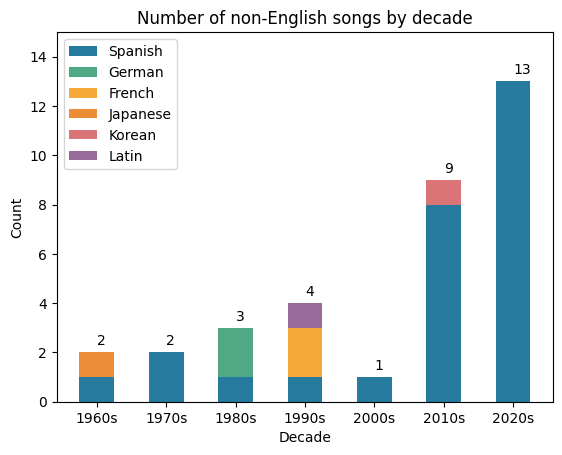

In [293]:
german = non_english_by_decade['German']
spanish = non_english_by_decade['Spanish']
french = non_english_by_decade['French']
japan = non_english_by_decade['Japanese']
korean = non_english_by_decade['Korean']
latin = non_english_by_decade['Latin']

plt.bar(non_english_by_decade.index, spanish, color='#267A9E', width=0.5)
plt.bar(non_english_by_decade.index, german, bottom=spanish, color='#51A885', width=0.5)
plt.bar(non_english_by_decade.index, french, bottom=spanish+german, color='#F5A936', width=0.5)
plt.bar(non_english_by_decade.index, japan, bottom=spanish+german+french, color='#ED8C37', width=0.5)
plt.bar(non_english_by_decade.index, korean, bottom=spanish+german+french+japan, color='#DB7476', width=0.5)
plt.bar(non_english_by_decade.index, latin, bottom=spanish+german+french+japan+korean, color='#986b9b', width=0.5)

# Add labels and title to the plot
plt.xlabel('Decade')
plt.ylabel('Count')
plt.ylim(0, 15)
plt.title('Number of non-English songs by decade')

# add value to the top of each bar 
for i in range(len(non_english_by_decade)):
#     plt.text(x=non_english_by_decade.index[i]-.5, y=non_english_by_decade.iloc[i, -1]+0.5, s=non_english_by_decade.iloc[i, -1].astype('int'), size=10)
    plt.annotate(non_english_by_decade.iloc[i, -1].astype('int'), xy=(non_english_by_decade.index[i], non_english_by_decade.iloc[i, -1] + 0.3))

# Show the plot
plt.legend(['Spanish', 'German', 'French', 'Japanese', 'Korean', 'Latin'])
plt.show()

In [236]:
synth_df[synth_df['Korean'] == 1]

,song,artist_clean,year,decade,lyrics,languages,German,English,Spanish,French,Japanese,Korean,Latin,total_non_english
4999,gangnam style,psy,2012,2010,oppan gang namseutayil kang namseutayil naje ...,ko,0,0,0,0,0,1,0,1


 distribution of non-english songs

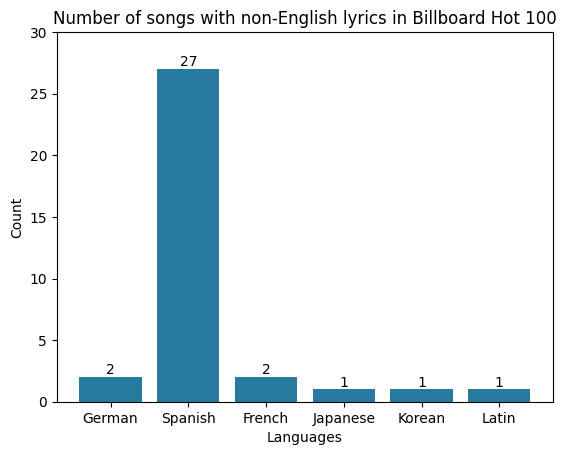

In [246]:
import matplotlib.pyplot as plt

# Extract the languages and their respective counts
temp_dict = lang_dict.copy()
temp_dict.pop('English')
languages = list(temp_dict.keys())
counts = list(temp_dict.values())

# Plot the bar chart
plt.bar(languages, counts, color='#267A9E')
plt.xlabel('Languages')
plt.ylabel('Count')
plt.ylim(0, 30)
plt.title('Number of songs with non-English lyrics in Billboard Hot 100')
for i in range(len(languages)):
    plt.annotate(counts[i], xy=(languages[i], counts[i]), ha='center', va='bottom')
plt.show()

In [238]:
non_english = 0

for lang in lang_dict.keys():
    if lang != 'English':
        non_english += lang_dict[lang]

total = sum(lang_dict.values())
print(non_english)
non_english / total * 100

34


0.5727762803234502